390 1228


<ipython-input-5-40b811c29316>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions'] = closing_price


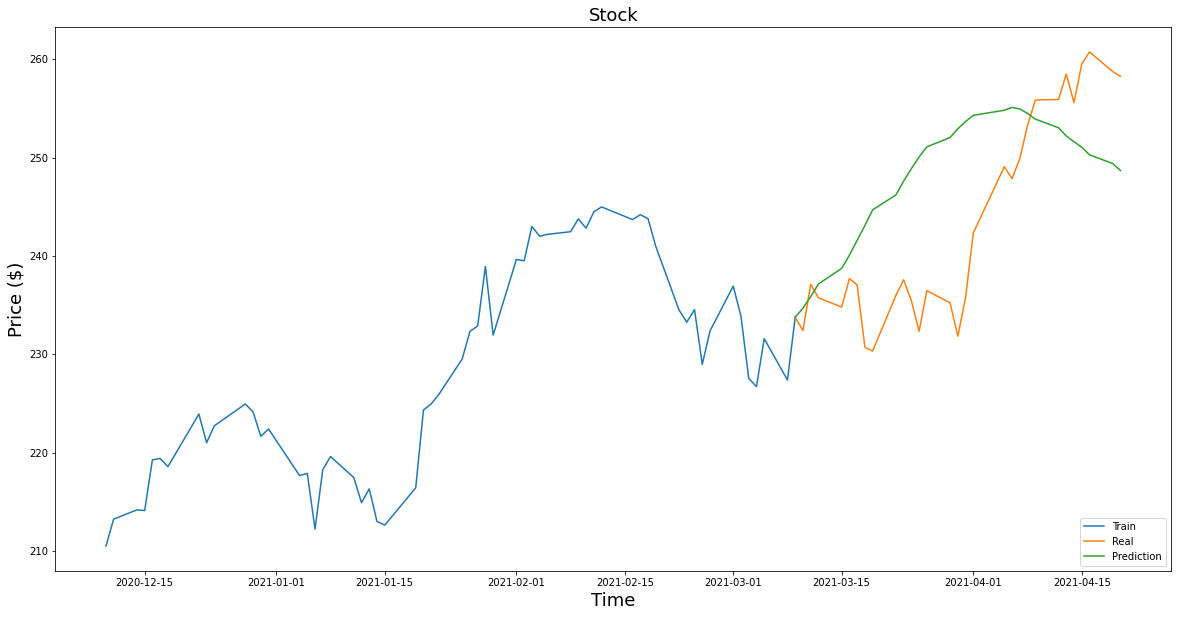

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler(feature_range=(0,1))
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense,SimpleRNN
from tensorflow import keras
model = keras.models.load_model('compiled_models/msft_30_360.h5')
days_watching = 360
predict_days = 30
df=pd.read_csv("data/MSFT_5Y.csv")
df.head()
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

test_threshold = df.shape[0]-predict_days

data = df.sort_index(ascending=True,axis=0)
df_new = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    df_new["Date"][i] = data['Date'][i]
    df_new["Close"][i] = data["Close"][i]
    
df_new.index = df_new.Date
df_new.drop("Date", axis=1, inplace=True)

final_dataset = df_new.values

train_data = final_dataset[0:test_threshold,:]
valid_data = final_dataset[test_threshold:,:]

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(final_dataset)

x_train_data,y_train_data = [],[]

for i in range(days_watching,len(train_data)-predict_days):
    x_train_data.append(scaled_data[i-days_watching:i,0])
    y_train_data.append(scaled_data[i+predict_days,0])
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)

x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

# inputs_data = df_new[0:].values
# inputs_data = df_new[len(df_new)-len(valid_data)-days_watching-predict_days:].values
inputs_data = df_new[len(df_new)-len(valid_data)-days_watching-predict_days:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

# print("days in test", inputs_data.shape[0])
# base_q = []
# base_q.append(inputs_data[0:days_watching,0])
# print(base_q)
# print(base_q[0])
# close_predict = []

X_test=[]
print(inputs_data.shape[0]-predict_days, test_threshold)
# for i in range(days_watching,inputs_data.shape[0]-predict_days):
for i in range(days_watching,days_watching+predict_days):
    X_test.append(inputs_data[i-days_watching:i,0])
X_test=np.array(X_test)
# print(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

closing_price=model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

train_data = df_new[:test_threshold+1]
valid_data = df_new[test_threshold:]
valid_data['Predictions'] = closing_price
first_vals = valid_data.iloc[0]
valid_data = valid_data.sub([0, first_vals['Predictions']-first_vals['Close']], axis='columns')
plt.title('Stock', fontsize=18)
plt.xlabel('Time',fontsize=18)
plt.ylabel('Price ($)',fontsize=18)
plt.plot((train_data["Close"])[-2*predict_days:])
plt.plot((valid_data[['Close',"Predictions"]]))
plt.legend(['Train', 'Real', 'Prediction' ], loc='lower right')

# lstm_model.save("saved_lstm_model.h5")